# Advanced Lane Finding


## The Project
The goals / steps of this project are the following:

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
Apply a distortion correction to raw images.
Use color transforms, gradients, etc., to create a thresholded binary image.
Apply a perspective transform to rectify binary image ("birds-eye view").
Detect lane pixels and fit to find the lane boundary.
Determine the curvature of the lane and vehicle position with respect to center.
Warp the detected lane boundaries back onto the original image.
Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Just import neededf Libs

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
to do the calibration , we use many images around 20 images.
I used the OpenCV functions findChessboardCorners and drawChessboardCorners to identify the locations of corners on a series of pictures of a chessboard taken from different angles.

failed to find corners for ./camera_cal\calibration1.jpg
failed to find corners for ./camera_cal\calibration4.jpg
failed to find corners for ./camera_cal\calibration5.jpg
(1280, 720)
(720, 1280)


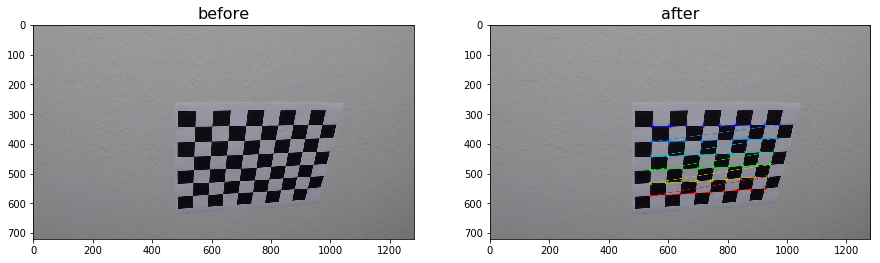

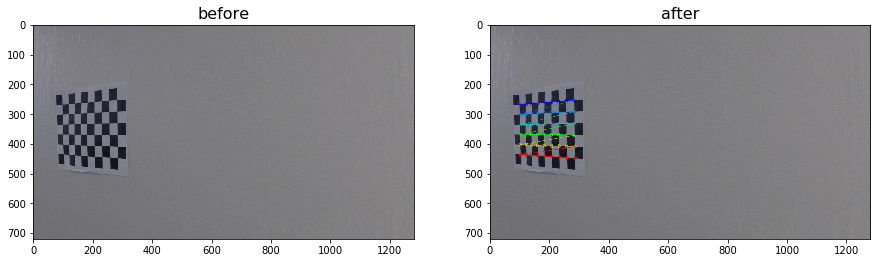

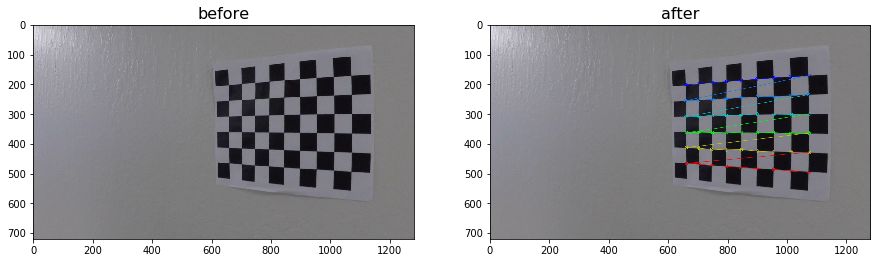

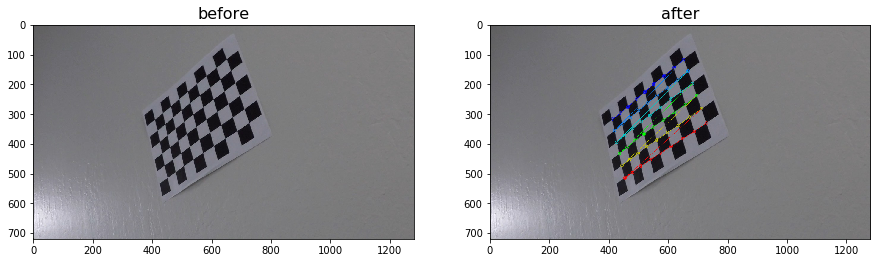

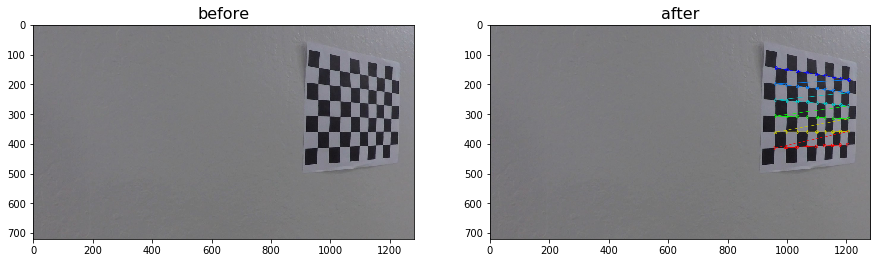

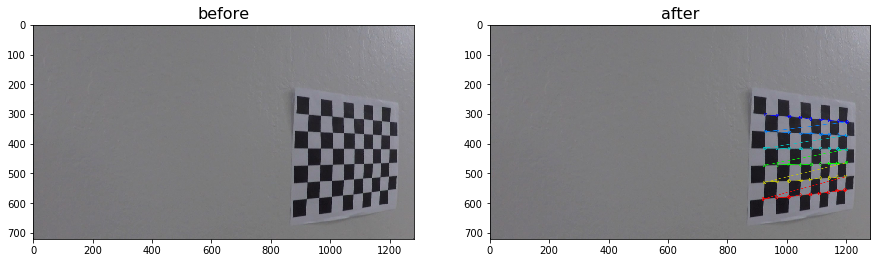

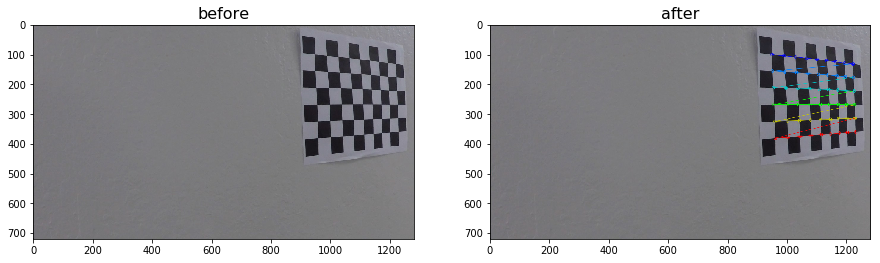

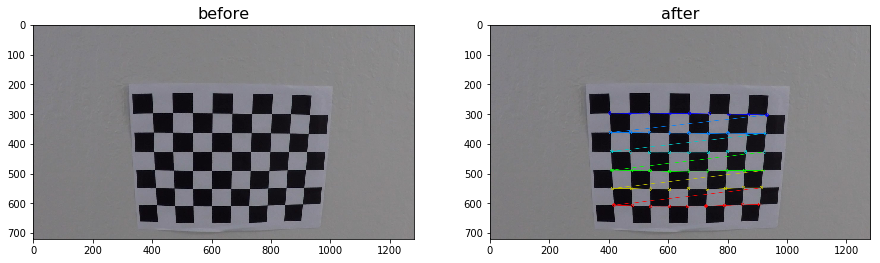

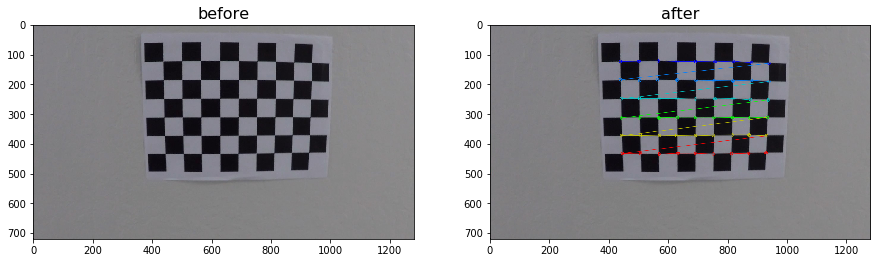

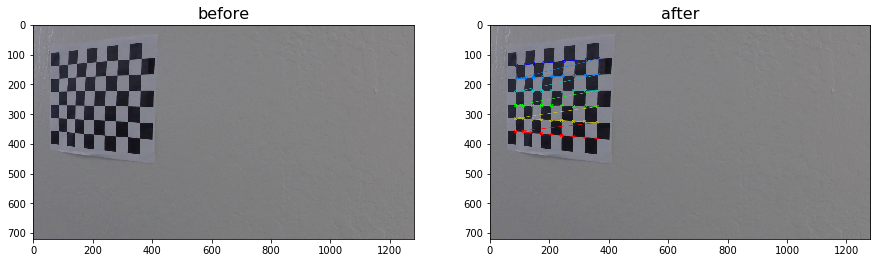

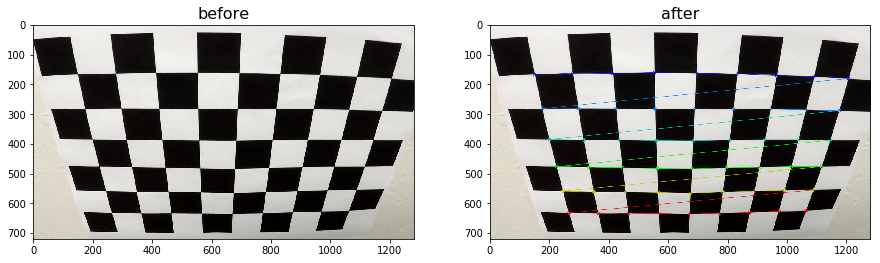

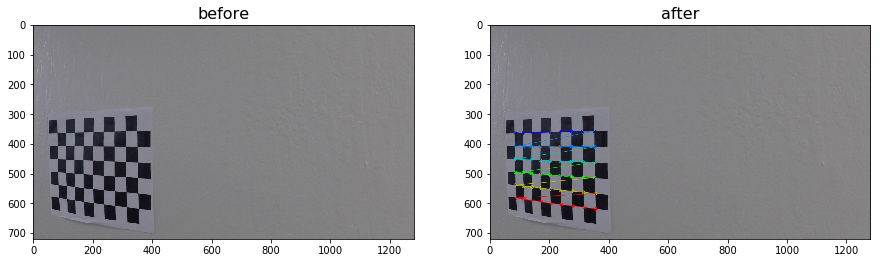

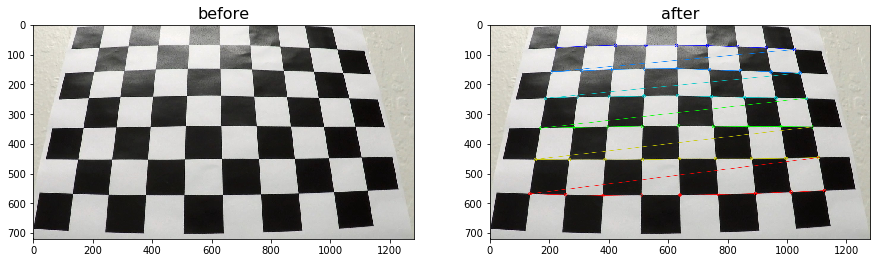

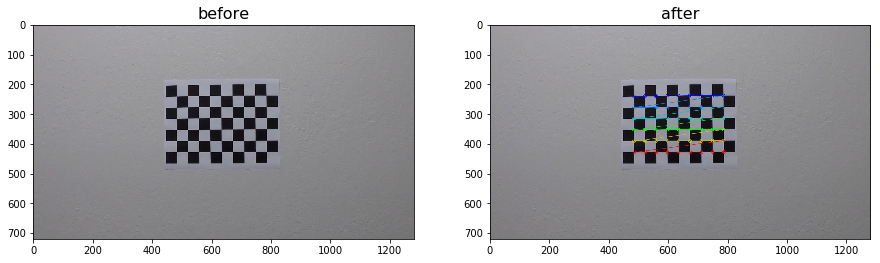

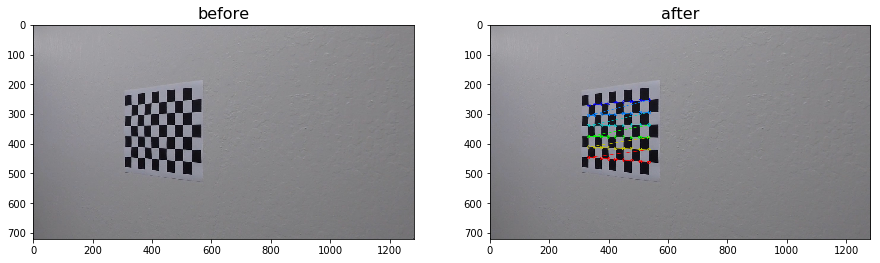

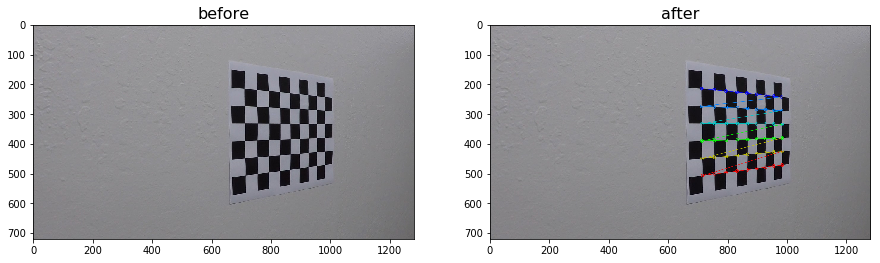

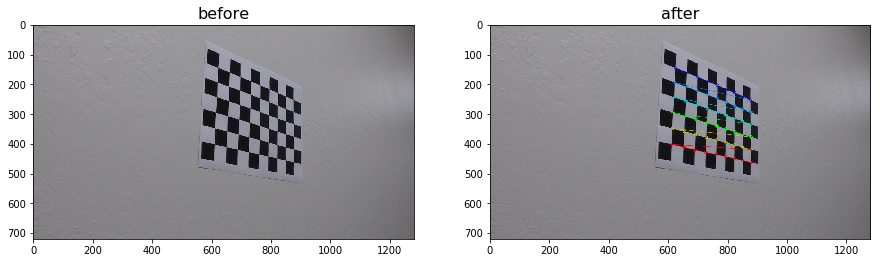

In [2]:
nx = 9  
ny = 6  

# Make a list of calibration images
image_pathes = glob.glob('./camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []
objp =  np.zeros((6*9,3),np.float32)
objp[:,:2] =  np.mgrid[0:9,0:6].T.reshape(-1,2)

for img_path in image_pathes:
    # Convert to grayscale
    
    img = mpimg.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        imgpoints.append(corners)
        objpoints.append(objp)
        #show images
        f, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,10))
        axis1.imshow(mpimg.imread(img_path))
        axis1.set_title('before', fontsize=16)
        axis2.imshow(img)
        axis2.set_title('after', fontsize=16)
    else:
        print ("failed to find corners for " + img_path)
print (gray.shape[::-1]) 
print (gray.shape) 
ret,cal_mtx,cal_dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

In [3]:

get_pathes = glob.glob('./test_images/*.jpg')
sample_image = mpimg.imread('./test_images/straight_lines1.jpg')

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    dst = cv2.undistort(img, cal_mtx, cal_dist, None, cal_mtx)   
    return dst

Some helper function to show images.

In [5]:
def show_images(image_before, Image_after):
    f, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,10))
    axis1.imshow(image_before,cmap='gray')
    axis1.set_title('before', fontsize=16)
    axis2.imshow(Image_after,cmap='gray')
    axis2.set_title('after', fontsize=16)
    
def show_Array_images(image_before):
    i=0
    for img in image_before:
        f, (axis1) = plt.subplots(1, 1, figsize=(15,10))
        axis1.imshow(image_before)
        axis1.set_title(++i, fontsize=16)
    


Step 2: Using thresholding teqniques just to get the white and the Yellow lanes colors.

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output
# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 50)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x = (cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y = (cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude
    gradmag = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image

    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def color_thresholds(img, HLS_s_threshold=(125, 255), HLS_h_threshold=(15,100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel > HLS_s_threshold[0]) & (s_channel <= HLS_s_threshold[1])] = 1
    
    h_channel = hls[:,:,0]
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > HLS_h_threshold[0]) & (h_channel <= HLS_h_threshold[1])] = 1
    
    
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    L_binary = np.zeros_like(hls_l)
    L_binary[(hls_l > 220) & (hls_l <= 255)] = 1
    
    
    img_binary = np.zeros_like(s_channel)
    
    img_binary[(s_binary == 1) & (h_binary==1) | (L_binary==1) | (lab_bthresh(img)==1)] =1 
    return img_binary




Step 3: Perspective Transform :
The goal of this step is to transform the undistorted image to a "birds eye view" of the road which focuses only on the lane lines and displays them in such a way that they appear to be relatively parallel to eachother (as opposed to the converging lines you would normally see).
To achieve the perspective transformation I first applied the OpenCV functions getPerspectiveTransform and warpPerspective which take a matrix of four source points on the undistorted image and remaps them to four destination points on the warped image.
The source and destination points were selected manually by visualizing the locations of the lane lines on a series of test images.

In [7]:
def birds_eye(img, display=True, read = True):
    img_size = (img.shape[1], img.shape[0])
    offset = 0
  #  src = np.float32([[490, 482],[810, 482],
    #                  [1250, 720],[40, 720]])
  #  dst = np.float32([[0, 0], [1280, 0], 
    #                 [1250, 720],[40, 720]])
    src = np.float32 ([
        [220, 651],
        [350, 577],
        [828, 577],
        [921, 651]
    ])

    dst = np.float32 ([
        [220, 651],
        [220, 577],
        [921, 577],
        [921, 651]
    ])

    
  
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(img,cmap='gray')
        ax1.set_title('Undistorted Image', fontsize=20)
        ax2.imshow(warped,cmap='gray')
        ax2.set_title('Undistorted and Warped Image', fontsize=20)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        return warped , Minv
    else:
        return warped , Minv

## Historgarm
a function to do histogram to identify the peaks / loction of the white and Yellow line to start ur search

In [8]:
def get_histogram(img,splot='n'):
    histogram = np.sum(birds[img.shape[0]//2:,:], axis=0)
    if splot == 'y':
        plt.plot(histogram) 
        return(histogram)
    else:
        return(histogram)

## Sliding Window

In [9]:
def sliding_windows(binary_warped):
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 50
    minpix = 1
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 255, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 255, 0]
    
 
    
    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx,lefty, rightx, righty ,leftx_base, rightx_base

## Curvature
Calculate crvature

In [10]:
def roc_in_meters(ploty, left_fit, right_fit, leftx,lefty ,rightx,righty):

    # Measure Radius of Curvature for each lane line
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    
    
    
    
    
   
    return left_curverad , right_curverad
        
 

# Warp the detected lane boundaries back onto the original image.


Just show a smample image after and before applying undistortion fcuntion

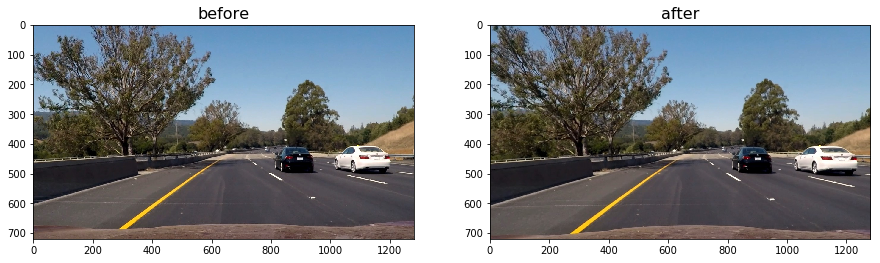

In [11]:
newimages=[]
for img_path in get_pathes:
    sample_image = mpimg.imread(img_path)
    undistorted = cal_undistort(sample_image, objpoints, imgpoints)
    newimages.append(undistorted)
show_images(sample_image,undistorted)

Apply the color treshold on one of the images to evaluate its efficiency 

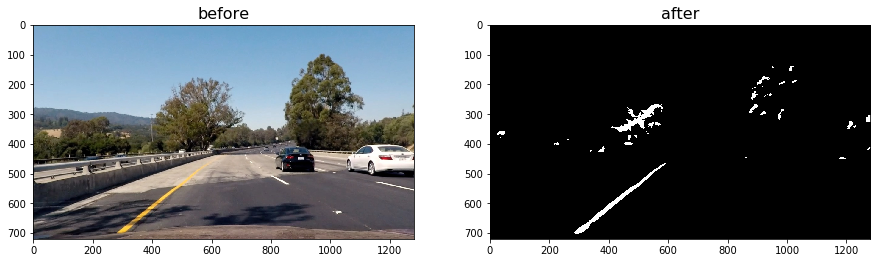

In [12]:
image = newimages[5]
color = lab_bthresh(image)
show_images(image,color)
   



Test with the sample images , till the bird eye view

In [13]:
def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    

    x = img.shape[1]
    y = img.shape[0]
    #print (str(x) + " , " + str(y))
    vertices = np.array([[(x*0.,y),(x*.475, y*.6), (x*.525, y*.6), (x,y)]], dtype=np.int32)
    vertices_2 = np.array([[(400,y),(600,450), (800,450), (1000,y)]], dtype=np.int32)

        
    mask = np.zeros_like(img) 
    mask_2 = np.zeros_like(img) 
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    cv2.fillPoly(mask_2, vertices_2, ignore_mask_color)
        
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    masked_image = cv2.bitwise_not(img, mask_2)
    return masked_image



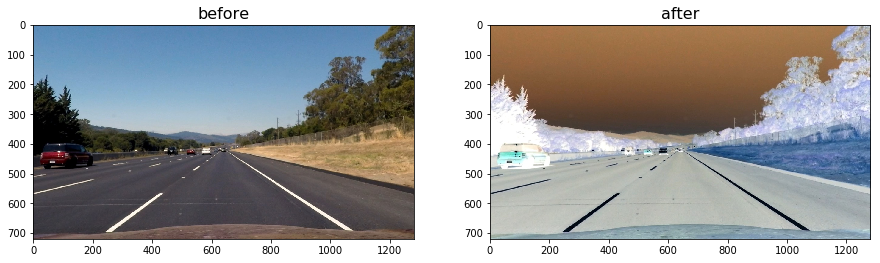

In [14]:
image = newimages[1]
reg = region_of_interest(image)
show_images(image,reg)

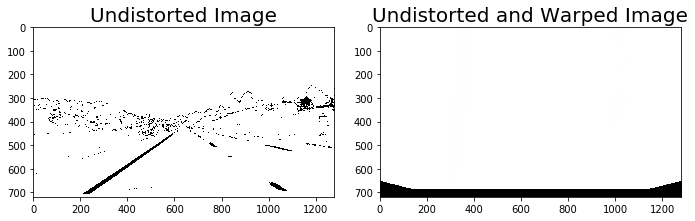

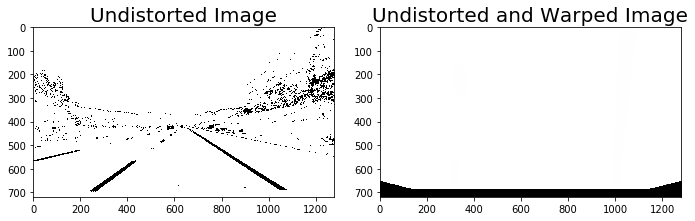

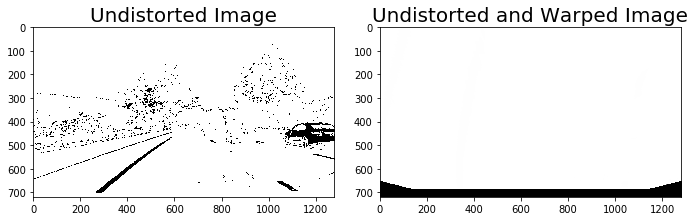

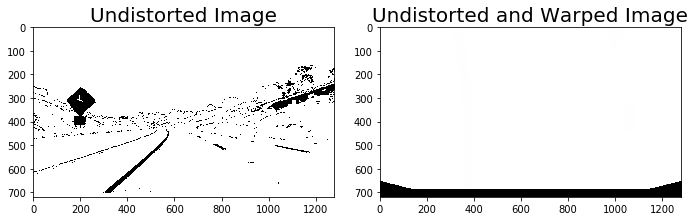

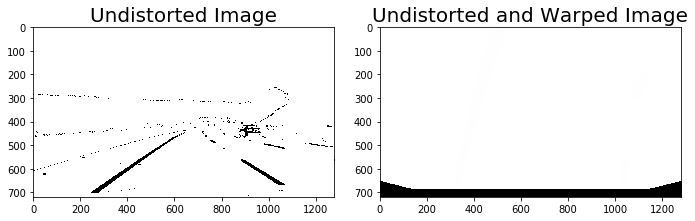

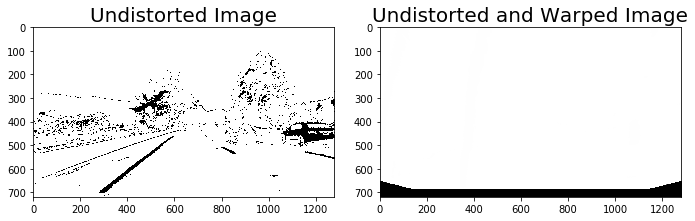

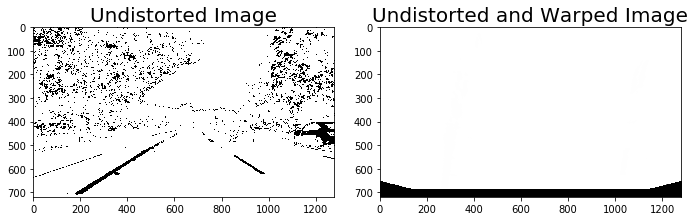

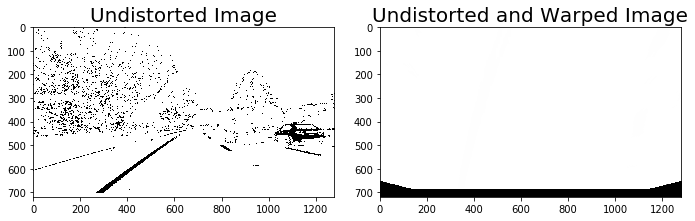

In [15]:
bird_views=[]
for image in newimages:
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(15, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(35, 255))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(60, 255))
    dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.7, 1.1))
    color = color_thresholds(image)
    
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    combined = np.zeros_like(img)

    combined[(gradx == 1) & (grady == 1) & (mag_binary == 1) | (color == 1) | (mag_binary == 1) & (dir_binary == 1)] = 1
    
    com = region_of_interest(combined)
    
    birds,M = birds_eye(com, display=True)
    
    ### experiment code
    bird_views.append(birds)
    


Detect lane pixels and fit to find the lane boundary.

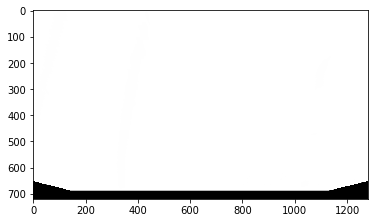

In [16]:
birds = bird_views[2]
historgram =get_histogram(birds)   
plt.imshow(birds, cmap='gray')



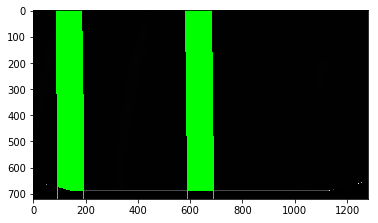

In [17]:
result, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty ,rightx,righty, leftx_base, rightx_base = sliding_windows(birds)
plt.imshow(result)


#### Wrapping

In [18]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    
 
        
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [19]:
def pos_center(img_center, leftx_base, rightx_base):
    poly_center = (leftx_base + rightx_base) / 2
    diff_pix = img_center - poly_center
    xm_per_pix = 3.5/1000
    posyapos = diff_pix * xm_per_pix
    return posyapos

In [20]:
def annotate(img, left_curverad, camera):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(img, 'Curvature: {0:6f} meters'.format(left_curverad), (10,30), font, 2, (255,0,0), 2)
    cv2.putText(img, 'Camera Offset: {0:6f} meters'.format(camera), (10,80), font,2, (0,0,255), 2)

I tend to add a sanity check as well to comapre previous line with current line , if devaition is huge i use the previous line points, this allow me to minimize errors in my calculation

In [31]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # # was the line detected in the last iteration?
        self.detected = True   
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = [[],[]]
        
def sanity_check(history, line):
    same = 0
    radius = 0
    intersect = 0
    distance = 0
    difference = 0
    sanity = False
    if history:       
        # Check if lines are the same
        if (line.current_fit[0] == line.current_fit[1]).all():
            sanity = True
         # Check if radius are similar
        if (abs(line.radius_of_curvature[0] - line.radius_of_curvature[1]) > 2000) and \
            (line.radius_of_curvature[0] < 4000) and (line.radius_of_curvature[1] < 4000):
            sanity = True
        # Check if polynomials intersect each other
        roots = np.roots(np.subtract(line.current_fit[0], line.current_fit[1]))
        real_value = roots.real[abs(roots.imag)<1e-5]
        if len(real_value) > 0 and all(abs(i) <=720 for i in real_value):
            sanity = True
        # Check distance on top and botton between the two lanes
        top = line.current_fit[0][2] - line.current_fit[1][2]
        botton = (line.current_fit[0][0]*720**2 + line.current_fit[0][1]*720 + line.current_fit[0][2]) - \
                 (line.current_fit[1][0]*720**2 + line.current_fit[1][1]*720 + line.current_fit[1][2])
        if abs(top - botton) > 300:
            sanity = True
        # Check differente between current and last lane identified for left and right lane
        if history[-1].detected:
            for i in range(2):
                if line.diffs[i][0] > 0.0002 or line.diffs[i][1] > 0.2 or line.diffs[i][2] > 50:
                    sanity = True
    return sanity

## Video Processing Pipeline:
After establishing a pipeline to process still images, the final step was to expand the pipeline to process videos frame-by-frame, to simulate what it would be like to process an image stream in real time on an actual vehicle.

My goal in developing a video processing pipeline was to create as smooth of an output as possible. To achieve this, I created a class for each of the left and right lane lines and stored features of each lane for averaging across frames.

The video pipeline first checks whether or not the lane was detected in the previous frame. If it was, then it only checks for lane pixels in close proximity to the polynomial calculated in the previous frame. This way, the pipeline does not need to scan the entire image, and the pixels detected have a high confidence of belonging to the lane line because they are based on the location of the lane in the previous frame.



In [32]:


history=[]
def pipline(img):
    
    line = Line()
    
    img_c = np.copy(img)
    image = cal_undistort(img_c, objpoints, imgpoints)
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(15, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(35, 255))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(60, 255))
    dir_binary = dir_threshold(image, sobel_kernel=9, thresh=(0.7, 1.1))
    color = color_thresholds(image)
    img_g = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    combined = np.zeros_like(img_g)

    combined[(gradx == 1) & (grady == 1) & (mag_binary == 1) | (color == 1) | (mag_binary == 1) & (dir_binary == 1)] = 1
    birds , Minv = birds_eye(combined, display=False)
    
    ### experiment code
    bird_views.append(birds)
     
    windows_img,ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, lefty ,rightx,righty, leftx_base, rightx_base = sliding_windows(birds)
    
    
    
    left_curverad, right_curverad = roc_in_meters(ploty, left_fit, right_fit, leftx,lefty, rightx,righty)
    center_pos =  pos_center(img.shape[1]/2,leftx_base,rightx_base)
    
    
    try:
        last = history[-1].current_fit
    except:
        last = None
        
    line.current_fit =  [left_fit, right_fit]
    
    line.radius_of_curvature  = [left_curverad ,right_curverad]
    line.line_base_pos = center_pos
    
    if history:
        for i in range(2):
            line.diffs[i] = [abs(a - b) for a, b in zip(line.current_fit[i], history[-1].current_fit[i])]
            
    if (sanity_check(history, line)):
        for i in range(2):
            line.current_fit[i] = history[-1].current_fit[i]
            line.detected = False  
            
    history.append(line)       
    annotate(img, line.radius_of_curvature[0],  center_pos)
    result = draw_lane(img ,birds,line.current_fit[0], line.current_fit[1], Minv)
    
    return result

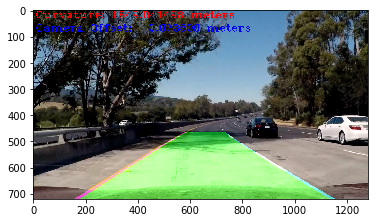

In [33]:
img = mpimg.imread("test_images/test5.jpg")
result = pipline(img)
plt.imshow(result)
 
    

In [34]:
from moviepy.editor import VideoFileClip

video_output3 = 'Project_video_output.mp4'
video_input3 = VideoFileClip('project_video.mp4')
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(pipline)
%time processed_video.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video Project_video_output.mp4
[MoviePy] Writing video Project_video_output.mp4



  5%|████▎                                                                           | 67/1261 [00:20<06:06,  3.26it/s]


 11%|████████▍                                                                      | 135/1261 [00:44<06:12,  3.02it/s]


 16%|████████████▋                                                                  | 203/1261 [01:08<05:58,  2.95it/s]


 21%|████████████████▉                                                              | 271/1261 [01:33<05:40,  2.91it/s]


 27%|█████████████████████▏                                                         | 339/1261 [01:57<05:20,  2.87it/s]


 32%|█████████████████████████▍                                                     | 407/1261 [02:23<05:00,  2.85it/s]


 38%|█████████████████████████████▊                                                 | 475/1261 [02:47<04:37,  2.83it/s]


 43%|██████████████████████████████████                                             | 543/1261 [03:12<04:14,  2.82it/s]


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:37<03:51,  2.81it/s]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [04:02<03:28,  2.80it/s]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [04:27<03:04,  2.79it/s]


 65%|███████████████████████████████████████████████████                            | 815/1261 [04:52<02:40,  2.78it/s]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [05:17<02:15,  2.78it/s]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [05:41<01:51,  2.78it/s]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [06:06<01:26,  2.78it/s]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [06:31<01:02,  2.78it/s]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [06:56<00:38,  2.78it/s]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [07:20<00:13,  2.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:34<00:00,  2.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Project_video_output.mp4 

Wall time: 7min 35s


## Conclusion

I was able to run the pipeline over the images, i think the result are quite okey.
i think i need to optimse the pipeline more, it takes too much time to process. 
probably we should lower rate frames , and may be smaller or lower quality images 
that could seed up the processing.
It took alot of time to fine tune the parameters , also i think this wont work on differnt enviroments.
There should be a way to auto calibrate colors, in differnt lighting or enviroments.